# Analyzing movie reviews using Watson NLP

This notebook demonstrates how to analyze movie reviews using Watson NLP.

The data that is used in this notebook is taken from the `Kaggle`, https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis with license CC0: Public Domain. The dataset has been downsampled for fast execution of the notebook. You can download the downsampled data from [GitHub Repo](https://github.ibm.com/hcbt/Watson-NLP/blob/main/Sentiment-Analysis/movies_small.csv)

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). This block extracts nouns from the movie reviews. The most frequently used nouns are typical aspects of a movie that review authors talk about.
- **Sentiment analysis** with the _Sentiment block_ (`sentiment-document_bert_multi_stock`). Sentiment analysis classifies the sentiment of the movie reviews into positive, negative or neutral sentiment. You will use the Sentiment block to analyze the sentiment for a complete review text as well as for individual sentences.
- **Aspect-oriented sentiment analysis** with the _Targeted Sentiment_ block (`sentiment-targeted_bert_multi_stock`). This focuses on the sentiment of sentences that contain a specific target span. You will learn how to use it to analyze the sentiment for the most frequent aspects that we extracted with the syntax analysis.

## Table of Contents


1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing & EDA](#EDA)

    1.   [Extract frequently mentioned movie review aspects](#extractNouns)

1.  [Model Building](#loadandpredict)

    1. [Extract document and sentence sentiment](#extractSentiment)
    1. [Identify nouns that drive sentiment](#sentenceSentiment)
    1. [Aspect-oriented sentiment analysis](#targetedSentiment)

1.  [Model Evaluation](#modelEvaluation)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
### 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime 22.1 on Python 3.9_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>


In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud

In [3]:
import os, types
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
import watson_nlp

<a id="loadData"></a>
## 2. Data Loading (movie reviews)

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out sentiment analysis on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>

<span style="color:blueviolet">We load the movie reviews into a DataFrame.</span>

<span style="color:blue">This data set contains 10000 movie reviews with labels.</span>

In [5]:
# load data set into a dataframe
buffer = project.get_file("movies_small.csv")
review_df = pd.read_csv(buffer)

# preview the data set
review_df.head()

,Unnamed: 0,text,label
0,0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...",0
1,1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some...",0
2,2,Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and wh...,0
3,3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",0
4,4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant mov...",1


In [6]:
# stopwords
from wordcloud import WordCloud,STOPWORDS
stopwords=set(STOPWORDS)

<a id="EDA"></a>
## 3. Data Processing & EDA

<a id="extractNouns"></a>
### 3.A Extract frequently mentioned movie aspects

<span style="color:blue">

You will extract the most frequently mentioned aspects (nouns) in the movie reviews for each movie to get to know what the audiences are talking about in their reviews.

For this, you will use the Watson NLP pre-trained syntax model to extract the most frequently used nouns from the reviews. These nouns help you to comprehend what the main message of the reviews is.</span>

<span style="color:blueviolet">Load the Watson NLP syntax model:.</span>



In [7]:
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))

#### Extract and store nouns and their lemmas

<span style="color:blue">The syntax model performs part-of-speech tagging (for nouns, pronouns, verbs, etc.) so that you can filter out all nouns from the reviews. Instead of retrieving the nouns as they occur in the review, the lemmatized version of the nouns (e.g. companies -> company) is stored. This allows you to create more accurate statistics over all noun-occurrences.</span>

<span style="color:blueviolet">Use the helper functions to identify the lemma form of nouns in the review text.</span>

In [8]:
# Helper methods
# extract the lemmatized nouns
def extract_nouns(review_text):
    # converting text into lower case before processing
    review_text =review_text.lower()
    syntax_result = syntax_model.run(review_text, parsers=('lemma', 'part_of_speech'))
    # filter nouns
    nouns = [token['lemma'] for token in syntax_result.to_dict()['tokens'] if ((token['part_of_speech'] == 'POS_PROPN' or token['part_of_speech'] == 'POS_NOUN') and len(token['lemma']) > 2)] 
    # remove stopwords
    nouns = [noun for noun in nouns if noun.upper() not in stopwords]
    return list(nouns)

# create a new dataframe with the corresponding nouns
def create_noun_dataframe(df):
    nouns = df['text'].apply(lambda text: extract_nouns(text))
    noun_df = pd.DataFrame(nouns)
    noun_df.rename(inplace=True, columns={'text':'Nouns'})
    return noun_df

<span style="color:blueviolet">Extract the lemmatized nouns and show them with the review text in which they occurred.</span>


In [9]:
noun_df = create_noun_dataframe(review_df)
sentiment_noun_df = review_df[['text', 'label']].merge(noun_df, how='left', left_index=True, right_index=True)
sentiment_noun_df.head()

,text,label,Nouns
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...",0,"[thunderbird, mate, school, thunderbird, school, lunch, school, one, art, form, child, movie, glimpse, child, point, theme, tune, score, thunderbird, morning, television, channel, rerun, series, wife, director, chair, version, waste, film, rubbish, remake, marionette, homo, error, judgment]"
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some...",0,"[movie, player, coke, chip, expectation, movie, point, movie, animation, story, voice, cast, comedy, kick, soundtrack, disappointment, return, review, paragraph, movie, point, scene, shock, return, display, case, expectation, music, imitation, movie, voice, cast, exception, character, voice, drawing, animation, sight, episode, story, time, episode, time, audience, movie, sequel, review, movie,..."
2,Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and wh...,0,"[time, past, need, time, other, war, moon, landing, flick, soap, opera, lowlife, trash, kid, grade, school, composition, meanie, movie, topic, money, thing, film, insight, underclass, time, slut, bar, lane, way, child, abuse, parent, kid, audience, abuse, flick, film]"
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",0,"[interest, movie, minute, movie, movie, acting, time, joke, script, point, story, time, sanity, horror]"
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant mov...",1,"[die, dad, army, fan, tape, time, brand, film, film, run, episode, man, hour, enemy, gate, battle, school, other, edge, introduction, captain, move, cheque, year, equipment, uniform, training, film, afternoon, draw, back, accent, letter, casting, film, carry, choice]"


### Display the 20 most frequent nouns as a bar chart and word cloud

<span style="color:blueviolet">Use the `explode` function to transform the noun list to separate rows for each noun. That way, you can count the occurrences for each noun in a subsequent step.</span>



In [10]:
exp_nouns = sentiment_noun_df.explode('Nouns')


<span style="color:blueviolet">Plot the most frequent nouns as a bar chart:</span>



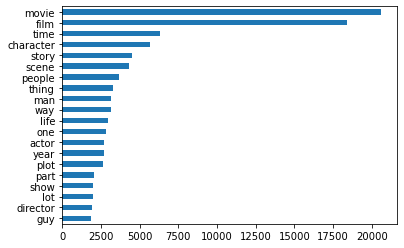

In [11]:
exp_nouns['Nouns'].value_counts().head(20).sort_values().plot(kind='barh') 

plt.show()

<span style="color:blueviolet">Create a word cloud for the most frequent nouns and show them:</span>



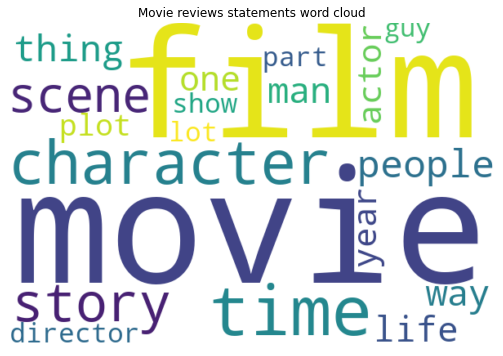

In [12]:
figure, ax1 = plt.subplots(ncols=1, figsize=(10,6))

wc = WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(exp_nouns['Nouns'].value_counts().head(20))
ax1.imshow(wc, interpolation="bilinear")
ax1.axis('off')
ax1.title.set_text("Movie reviews statements word cloud")
plt.show()


<a id="loadandpredict"></a>
## 4. Model Building

<a id="extractSentiment"></a>
### 4.A Extract document and sentence sentiment

<span style="color:darkred">
Are reviewers talking positively or negatively about the movies? Sentiment can be extracted for the complete review and for individual sentences. The sentiment extraction helpers can extract both sentiment levels. </span>

<span style="color:blueviolet">Load the *sentiment-document_bert_multi_stock* (BERT) sentiment model for English:</span>

In [17]:
sentiment_model = watson_nlp.load(watson_nlp.download('sentiment-document_bert_multi_stock'))
# sentiment_model = watson_nlp.load(watson_nlp.download('sentiment_document-cnn-workflow_en_stock'))

./build/lib/watson_nlp/blocks/document_sentiment/bert/bert.py:162: DeprecationWarning: Call to deprecated class BERT. (BERT Document Sentiment Class is deprecated. Please use watson_nlp.blocks.sentiment.sentence_sentiment_bert.SentenceSentimentBERT instead.) -- Deprecated since version 3.X.X.


### Extract the overall sentiment of the review and the sentiment for each sentence

<span style="color:blueviolet">Helper functions to extract the sentiment in the review text and create a dataframe.:</span>


In [18]:
def extract_sentiment(review_text):
    # run the syntax model
    # converting review text into lower case
    review_text = review_text.lower()
    syntax_result = syntax_model.run(review_text, parsers=('token', 'lemma', 'part_of_speech'))
    # run the sentiment model on the result of the syntax analysis
    sentiment_result = sentiment_model.run(syntax_result, sentence_sentiment=True)
    
    document_sentiment = sentiment_result.to_dict()['label']
    sentence_sentiment = [(sm['span']['text'], sm['label']) for sm in sentiment_result.to_dict()['sentiment_mentions']]
    return (document_sentiment, sentence_sentiment)

# Helper method to create a new dataframe with the corresponding sentiment
def create_sentiment_dataframe(df):
    sentiment = df['text'].apply(lambda text: extract_sentiment(text))
    sentiment_df = pd.DataFrame.from_records(sentiment, columns=('Document Sentiment', 'Sentence Sentiment'))
    return sentiment_df

<span style="color:blueviolet">Extract the sentiment and display it with the review text. **Note:** This cell will run for several minutes</span>



In [19]:
review_df_small = review_df

In [20]:
sentiment_df = create_sentiment_dataframe(review_df_small)
review_sentiment_df = review_df_small[['text', 'label']].merge(sentiment_df[['Document Sentiment']], how='left', left_index=True, right_index=True)
review_sentiment_df.head()

,text,label,Document Sentiment
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...",0,SENT_NEGATIVE
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some...",0,SENT_NEGATIVE
2,Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and wh...,0,SENT_NEGATIVE
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",0,SENT_NEGATIVE
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant mov...",1,SENT_POSITIVE


<a id="sentenceSentiment"></a>
### 4.B Identify nouns that drive sentiment

<span style="color:blueviolet">
We now identify the most frequently used nouns in sentences with positive or negative sentiment.</span>

<span style="color:blue">In the sentiment extraction described in the sections above, we extracted the sentence sentiment along with the document sentiment. The result was stored in the `sentiment_df` dataframe.</span>

In [21]:
# For each news headline we create a row for each sentence and the corresponding sentiment.
review_sentence_sentiment_df = review_df_small[['text']].merge(sentiment_df[['Sentence Sentiment']], how='left', left_index=True, right_index=True)
exp_review_sentence_sentiment_df = review_sentence_sentiment_df.explode('Sentence Sentiment')
exp_review_sentence_sentiment_df.reset_index(inplace=True, drop=True)
exp_review_sentence_sentiment_df[['Sentence', 'Sentiment']] = pd.DataFrame(exp_review_sentence_sentiment_df['Sentence Sentiment'].tolist(), 
                                                                          index=exp_review_sentence_sentiment_df.index)
exp_review_sentence_sentiment_df.head()

,text,Sentence Sentiment,Sentence,Sentiment
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...","(i grew up (b., SENT_NEUTRAL)",i grew up (b.,SENT_NEUTRAL
1,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...","(1965) watching and loving the thunderbirds., SENT_POSITIVE)",1965) watching and loving the thunderbirds.,SENT_POSITIVE
2,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...","(all my mates at school watched., SENT_POSITIVE)",all my mates at school watched.,SENT_POSITIVE
3,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...","(we played ""thunderbirds"" before school, during lunch and after school., SENT_NEUTRAL)","we played ""thunderbirds"" before school, during lunch and after school.",SENT_NEUTRAL
4,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...","(we all wanted to be virgil or scott., SENT_NEUTRAL)",we all wanted to be virgil or scott.,SENT_NEUTRAL


<span style="color:blueviolet">Extract nouns from the sentences/sentiment dataframe:</span>

In [22]:
sent_level_nouns = exp_review_sentence_sentiment_df['Sentence'].apply(lambda text: extract_nouns(text))
sent_level_nouns_df = pd.DataFrame(sent_level_nouns)
sent_level_nouns_df.rename(inplace=True, columns={'Sentence':'Nouns'})
sentences_noun_df = exp_review_sentence_sentiment_df[['Sentence', 'Sentiment']].merge(sent_level_nouns_df, how='left', left_index=True, right_index=True)
sentences_noun_df.head()

,Sentence,Sentiment,Nouns
0,i grew up (b.,SENT_NEUTRAL,[]
1,1965) watching and loving the thunderbirds.,SENT_POSITIVE,[thunderbird]
2,all my mates at school watched.,SENT_POSITIVE,"[mate, school]"
3,"we played ""thunderbirds"" before school, during lunch and after school.",SENT_NEUTRAL,"[thunderbird, school, lunch, school]"
4,we all wanted to be virgil or scott.,SENT_NEUTRAL,[]


In [23]:
# Explode nouns and create dataframes for positive and negative sentiments for each movie.
exp_sent_nouns = sentences_noun_df.explode('Nouns')[['Sentiment', 'Nouns']]
neg_nouns = exp_sent_nouns.query("Sentiment == 'SENT_NEGATIVE'")
pos_nouns = exp_sent_nouns.query("Sentiment == 'SENT_POSITIVE'")

# Remove top 3 common words form positive & negative sentiment.
# Taking top 3 keys from positive & Negative sentiment
top_keys_pos = pos_nouns['Nouns'].value_counts().head(3).keys()
top_keys_neg = neg_nouns['Nouns'].value_counts().head(3).keys()

# Removing top 3 keys from postivie & negative nouns
pos_nouns = pos_nouns[~pos_nouns['Nouns'].isin(top_keys_pos)]
neg_nouns = neg_nouns[~neg_nouns['Nouns'].isin(top_keys_neg)]

# Helper method to create a word cloud
def generate_word_cloud(df):
    return WordCloud(width=600, height=400, background_color ='white').generate_from_frequencies(df['Nouns'].value_counts().head(20))

#### Show the most frequent nouns in positive sentences.

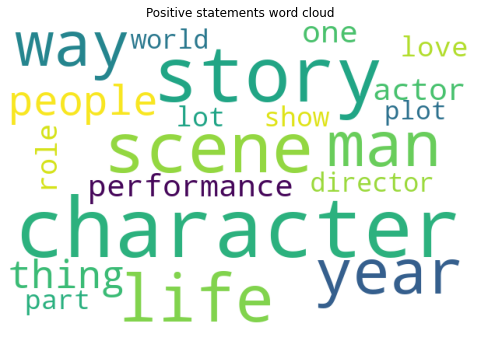

In [24]:
figure, ax1 = plt.subplots(ncols=1, figsize=(10,6))
figure.tight_layout(pad=5)

ax1.imshow(generate_word_cloud(pos_nouns))
ax1.axis('off')
ax1.title.set_text("Positive statements word cloud")

plt.show()

<span style="color:blue">In this case, the word clouds show that the most positive sentiments comes from the reviews with words like film, movie, time, story, character etc. So, the audience must love the film/movie when the story and character was good and it was mentioned in the reviews.</span>

#### Show the most frequent nouns in negative sentences.

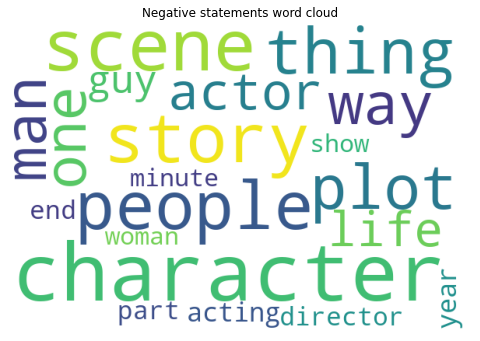

In [25]:
figure, ax1 = plt.subplots(ncols=1, figsize=(10,6))
figure.tight_layout(pad=5)

ax1.imshow(generate_word_cloud(neg_nouns))
ax1.axis('off')
ax1.title.set_text("Negative statements word cloud")

plt.show()

<span style="color:blue">In this case, the word clouds show that the most negative sentiments comes from reviews with words like time, character, scene, director. So, the audience might not have liked movies with poor direction, character and scenes in the movie.</span>

#### Show the nouns that "drive" sentiment for each review

<span style="color:blueviolet">We create a crosstab between nouns and the resulting sentence sentiment, and correlate them. The darker the cell, the more often does a noun occur in a sentence of a certain polarity. </span>

In [26]:
# create a data frame that only contains the nouns that appear more than 1000 times in the reviews
nounFrequency = exp_sent_nouns['Nouns'].value_counts()
frequent_values = nounFrequency[nounFrequency >= 1000].index
freq_sent_nouns = exp_sent_nouns[exp_sent_nouns['Nouns'].isin(frequent_values)]

freq_sent_nouns_review = freq_sent_nouns

<AxesSubplot:title={'center':'Sentiment Correlation'}, xlabel='Sentiment', ylabel='Nouns'>

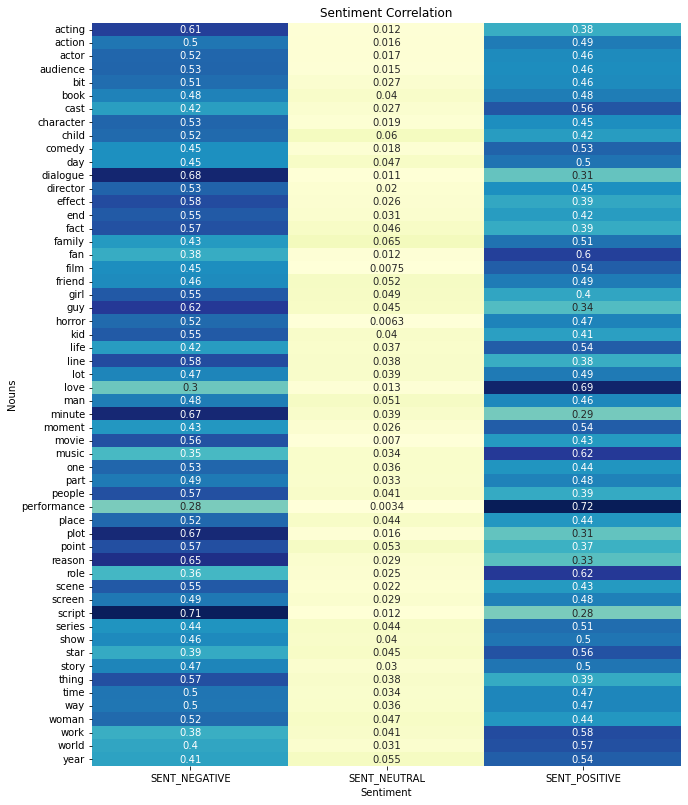

In [27]:
import seaborn as sns

figure, ax1 = plt.subplots(ncols=1, figsize=(10,12))
figure.tight_layout(pad=5)

ax1.title.set_text("Sentiment Correlation")

#sns.set(rc = {'figure.figsize':(5,12)})
sns.heatmap(pd.crosstab(freq_sent_nouns_review['Nouns'], freq_sent_nouns_review['Sentiment'], normalize='index'), 
            annot=True, cbar=False, cmap="YlGnBu", ax=ax1)

<span style="color:blue">

- `script` is the most contributing factor to negative sentiments
- `performance` and `love` are the most contributing factors to positive sentiments
- None of the nouns are strongly contributing to neutral sentiments which makes sense since the dataset doesn't contain neutral sentiment.

</span>

<a id="targetedSentiment"></a>
### 4.C Aspect-oriented sentiment analysis

The Targets Sentiment Extraction block contains algorithms for the task of extracting the sentiments expressed in text and identifying the targets of those sentiments.

For example, given the input:

“The served food was delicious, yet the service was slow.”

The block identifies that there is a positive sentiment expressed towards the target “food”, and a negative sentiment expressed towards “service”.

<span style="color:darkred">Let's see how the sentiment for these aspects (script, performance and love) looks like. For this, use the Watson NLP targeted sentiment model to extract the sentiment that is specific to the most frequently used nouns in the movie revies.</span>

<span style="color:blueviolet">Load the syntax model for English and the targeted BERT sentiment model:</span>

In [28]:
targeted_sentiment_model = watson_nlp.load(watson_nlp.download('sentiment-targeted_bert_multi_stock'))

./build/lib/watson_nlp/blocks/targeted_sentiment/bert.py:169: DeprecationWarning: Call to deprecated class BERT. (BERT Targeted Sentiment Class is deprecated. Please use watson_nlp.blocks.sentiment.sentence_sentiment_bert.SentenceSentimentBERT instead.) -- Deprecated since version 3.X.X.


<span style="color:blueviolet">Use a helper method to extract the sentiment for each target and the sentences containing the target as evidence.</span>

In [29]:
def extract_targeted_sentiment(review_text, target_words):
    # run the syntax model
    syntax_result = syntax_model.run(review_text, parsers=('token', 'lemma', 'part_of_speech'))
    # extract the spans for the target words
    targets = watson_nlp.toolkit.get_target_spans(review_text, target_words)
    # run the sentiment model on the result of syntax and the target words
    sentiment_result = targeted_sentiment_model.run(syntax_result, targets)
    
    # iterate over all target aspects
    target_sentiments = []
    for idx, val in enumerate(target_words):
        sentiment_prediction = sentiment_result.to_dict()['sentiment_predictions'][idx]
        sentiment_mentions = None
        if sentiment_prediction['sentiment_mentions'] is not None:
            sentiment_mentions = [(sm['span']['text'], sm['label']) for sm in sentiment_prediction['sentiment_mentions']]
        target_sentiments.append(sentiment_prediction['label'])
        target_sentiments.append(sentiment_mentions)
    return target_sentiments

<span style="color:blueviolet">Extract the sentiment specifically for *script*, *performance* and *love*. **Note:** this cell will run for several minutes.</span>

In [30]:
# extract sentiment targeted against specific aspects
aspects = ('performance', 'script', 'love')
aspect_sentiment = review_df_small['text'].apply(lambda text: extract_targeted_sentiment(text, aspects))
target_sentiment_df = pd.DataFrame.from_records(aspect_sentiment)
target_sentiment_df.columns=("Sentiment 'performance'", "Evidences 'performance'", "Sentiment 'script'", "Evidences 'script'", "Sentiment 'love'", "Evidences 'love'")
target_sentiment_df = review_df_small[['text','label']].merge(target_sentiment_df, how='left', left_index=True, right_index=True)
target_sentiment_df.head()

The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.


The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were found for computing predictions! 
                 This could have happened because the input targets were not found in the text.
The targets specified were not found in the text, and therefore the list of input sentences for computing predictions is empty!
No input sentences were fo

,text,label,Sentiment 'performance',Evidences 'performance',Sentiment 'script',Evidences 'script',Sentiment 'love',Evidences 'love'
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...",0,SENT_UNSET,None,SENT_UNSET,None,SENT_POSITIVE,"[(I took my children to see the movie hoping they would get a glimpse of what I loved as a child., SENT_POSITIVE)]"
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some...",0,SENT_UNSET,None,SENT_UNSET,None,SENT_UNSET,None
2,Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and wh...,0,SENT_UNSET,None,SENT_UNSET,None,SENT_UNSET,None
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",0,SENT_UNSET,None,SENT_NEGATIVE,"[(The movie is too long, the acting is most of the time a Joke and the script is horrible., SENT_NEGATIVE)]",SENT_UNSET,None
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant mov...",1,SENT_UNSET,None,SENT_UNSET,None,SENT_UNSET,None


#### Display the sentiment for selected aspects

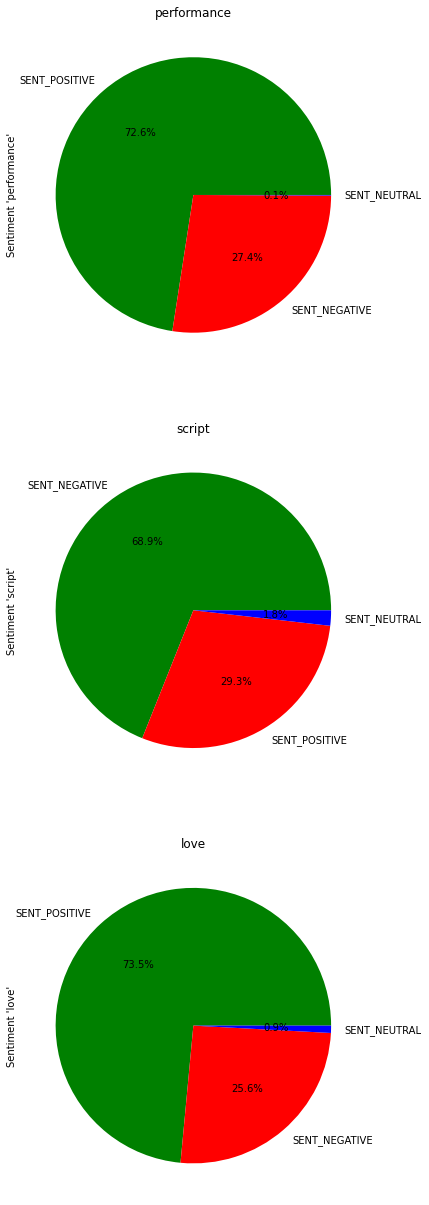

In [31]:
# plot the figures for each hotel side by side
figure, (ax1, ax3, ax5) = plt.subplots(nrows=3, ncols=1, figsize=(12,18))
figure.tight_layout(pad=5)
target_sentiment_df["Sentiment 'performance'"][target_sentiment_df["Sentiment 'performance'"] != "SENT_UNSET"].value_counts().plot(kind='pie', ax=ax1, colors=['g','r','b'], autopct='%1.1f%%') 
ax1.title.set_text('performance')
target_sentiment_df["Sentiment 'script'"][target_sentiment_df["Sentiment 'script'"] != "SENT_UNSET"].value_counts().plot(kind='pie', ax=ax3, colors=['g','r','b'], autopct='%1.1f%%') 
ax3.title.set_text('script')
target_sentiment_df["Sentiment 'love'"][target_sentiment_df["Sentiment 'love'"] != "SENT_UNSET"].value_counts().plot(kind='pie', ax=ax5, colors=['g','r','b'], autopct='%1.1f%%') 
ax5.title.set_text('love')

plt.show()

<a id="modelEvaluation"></a>
## 5. Model Evaluation

In [32]:
def convertToList(x):
    return [x]

In [33]:
def input_data_prep(df):
    df['weight'] = 1
    df.rename(columns={'label': 'labels'}, inplace=True)
    df = df[['text', 'weight', 'labels']]
    df['labels'] = df['labels'].replace({0: 'negative', 1: 'positive'})
#     df['labels'] = df['labels'].str.split(',')
    df['labels'] = df['labels'].apply(convertToList)
    display(df.head(5))
    return df

In [34]:
review_df_processed = input_data_prep(review_df)
test_file = './test_data.json'
review_df_processed.to_json(test_file, orient='records')

,text,weight,labels
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The onl...",1,[negative]
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some...",1,[negative]
2,Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and wh...,1,[negative]
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",1,[negative]
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant mov...",1,[positive]


In [35]:
pre_eval_func = lambda x: syntax_model.run_batch(x)
sentiment_model.find_label_func

results = sentiment_model.evaluate_quality(test_file, pre_eval_func)

<div class="alert alert-block alert-success">
<b>Model evaluation results.</b></div>

In [36]:
results

{'negative': {'precision': 0.8592734225621415,
  'recall': 0.891136228435455,
  'f1-score': 0.8749148252701255,
  'support': 5043},
 'neutral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'positive': {'precision': 0.885228703315149,
  'recall': 0.8511196288077466,
  'f1-score': 0.8678391442970277,
  'support': 4957},
 'accuracy': 0.8713,
 'macro avg': {'precision': 0.5815007086257635,
  'recall': 0.5807519524144006,
  'f1-score': 0.5809179898557177,
  'support': 10000},
 'weighted avg': {'precision': 0.8721394552314072,
  'recall': 0.8713,
  'f1-score': 0.871407410211761,
  'support': 10000}}

<span style="color:blue">As you can observe here that the overall accuracy, precision and recall values are 0.87 each. This has been achieved by evaluating an Out-of-the-box (OOB) model without training it on the IMDB Movie reviews dataset. If you want a better performance or custom model, you can follow the next tutorial in this learning path where you will be fine-tuning/re-training a pre-trained BERT based sentiment analysis model from the Watson NLP library on the same dataset.</span>

<a id="summary"></a>
## 6. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained models for syntax analysis and sentiment classification.</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the hosting [GitHub repository](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation